<a href="https://colab.research.google.com/github/JohanSantanaGalvanJob/TensorflowJS-With-Flower-Images/blob/master/TensorflowJS_With_Flower_Images_Johan_Santana_Galv%C3%A1n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Johan Santana Galvan

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import keras
import urllib.request
import zipfile
import cv2
import os
import tempfile
import glob
import requests
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
url_train = "https://github.com/JohanSantanaGalvanJob/TensorflowJS-With-Flower-Images/archive/refs/heads/master.zip"

In [ ]:
def download_and_extract(url, extract_dir):
    # Descargar el archivo zip
    response = requests.get(url)
    with open('temp.zip', 'wb') as f:
        f.write(response.content)

    # Extraer el archivo zip
    with zipfile.ZipFile('temp.zip', 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

In [ ]:
extract_dir = tempfile.mkdtemp()

# Descargar y extraer el repositorio
download_and_extract(url_train, extract_dir)

# Directorio donde se encuentran las imágenes
images_dir_train = os.path.join(extract_dir, "TensorflowJS-With-Flower-Images-master", "train")

In [ ]:
MAP_CHARACTERS = {
    0: 'daisy', 1: 'dandelion', 2: 'rose',
    3: 'sunflower', 4: 'tulip'
}

In [ ]:
IMG_SIZE = 64

In [ ]:
def load_train_set(dirname, map_characters, selected_test_images, verbose=True):
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith('jpg')]

        # Filtrar las imágenes seleccionadas para el conjunto de prueba
        images = [image for image in images if os.path.join(character, image) not in selected_test_images]
        if verbose:
            print("Leyendo {} imágenes encontradas de {} TRAIN".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image, (IMG_SIZE, IMG_SIZE)))
            y_train.append(label)

    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    X_test = []
    y_test = []
    selected_images_count = {}  # Contador para el número de imágenes seleccionadas por carpeta
    reverse_dict = {v: k for k, v in map_characters.items()}

    selected_test_images = set()  # Conjunto para almacenar los nombres de archivo de las imágenes seleccionadas para el conjunto de prueba

    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith('jpg')]
        if verbose:
            print("Leyendo {} imágenes encontradas de {} TEST".format(len(images), character))
        images_to_pick = max(1, int(len(images) * 0.2))  # Selecciona el 20% de las imágenes de la carpeta
        selected_images = random.sample(images, images_to_pick)
        selected_images_count[character] = len(selected_images)  # Guarda el número de imágenes seleccionadas
        for image_name in selected_images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_test.append(cv2.resize(image, (IMG_SIZE, IMG_SIZE)))
            y_test.append(reverse_dict[character])
            selected_test_images.add(os.path.join(character, image_name))  # Agrega el nombre de archivo al conjunto de imágenes seleccionadas

    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
        print("Número de imágenes seleccionadas por carpeta:")
        for character, count in selected_images_count.items():
            print("{}: {}".format(character, count))

    return np.array(X_test), np.array(y_test), selected_test_images

In [ ]:
X_test, y_test, test_images = load_test_set(images_dir_train, MAP_CHARACTERS)
X_train, y_train = load_train_set(images_dir_train, MAP_CHARACTERS, test_images)

Leyendo 501 imágenes encontradas de daisy TEST
Leyendo 646 imágenes encontradas de dandelion TEST
Leyendo 497 imágenes encontradas de rose TEST
Leyendo 495 imágenes encontradas de sunflower TEST
Leyendo 607 imágenes encontradas de tulip TEST
Leídas 548 imágenes de test
Número de imágenes seleccionadas por carpeta:
daisy: 100
dandelion: 129
rose: 99
sunflower: 99
tulip: 121
Leyendo 401 imágenes encontradas de daisy TRAIN
Leyendo 517 imágenes encontradas de dandelion TRAIN
Leyendo 398 imágenes encontradas de rose TRAIN
Leyendo 396 imágenes encontradas de sunflower TRAIN
Leyendo 486 imágenes encontradas de tulip TRAIN


In [ ]:
perm = np.random.permutation(len(X_train))
X_train, y_train = X_train[perm], y_train[perm]

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
def visualize_example(x):
  plt.figure()
  plt.imshow(x)
  plt.colorbar()
  plt.grid(False)
  plt.show()

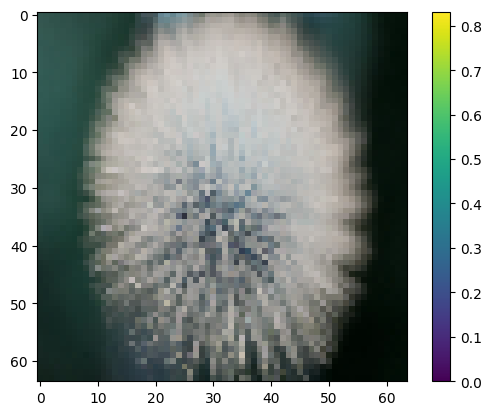

dandelion
(64, 64, 3)


In [ ]:
visualize_example(X_train[70]) # Visualiza la imagen normalizada con valores de 0 a 1
print(MAP_CHARACTERS[y_train[70]]) # Acceso al diccionario
print(X_train[70].shape[0:3]) # Dimensiones de la imagen tras resize con los 3 canales RGB

In [ ]:
num_classes=6
epochs=5
img_rows,img_cols=IMG_SIZE,IMG_SIZE
input_shape=(img_rows,img_cols,3) #(64,64,3)

In [ ]:
# convert class vectors to binary class matrices
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [ ]:
X_train.shape

(2198, 64, 64, 3)

In [ ]:
y_train.shape

(2198, 6)

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(64, kernel_size=(3, 3), data_format="channels_last", input_shape=(64, 64, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.summary()
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 256)         0

In [ ]:
history=model.fit(X_train, y_train, epochs=15, validation_split = 0.2)

Epoch 1/15
55/55 [==============================] - 41s 704ms/step - loss: 1.5318 - accuracy: 0.3151 - val_loss: 1.2458 - val_accuracy: 0.4273
Epoch 2/15
55/55 [==============================] - 39s 718ms/step - loss: 1.2965 - accuracy: 0.4443 - val_loss: 1.0806 - val_accuracy: 0.5636
Epoch 3/15
55/55 [==============================] - 40s 730ms/step - loss: 1.1748 - accuracy: 0.5017 - val_loss: 1.0184 - val_accuracy: 0.6045
Epoch 4/15
55/55 [==============================] - 39s 710ms/step - loss: 1.0297 - accuracy: 0.5694 - val_loss: 1.0385 - val_accuracy: 0.6000
Epoch 5/15
55/55 [==============================] - 40s 721ms/step - loss: 0.9668 - accuracy: 0.6149 - val_loss: 0.8885 - val_accuracy: 0.6818
Epoch 6/15
55/55 [==============================] - 39s 711ms/step - loss: 0.8623 - accuracy: 0.6655 - val_loss: 0.9311 - val_accuracy: 0.6682
Epoch 7/15
55/55 [==============================] - 39s 716ms/step - loss: 0.7867 - accuracy: 0.6815 - val_loss: 0.8610 - val_accuracy: 0.6795

In [ ]:
def plot_acc(history, title="Model Accuracy"):
  """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
def plot_loss(history, title="Model Loss"):
  """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

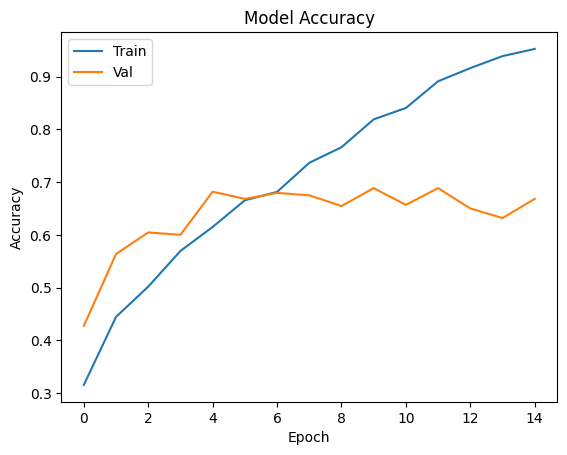

In [ ]:
plot_acc(history)

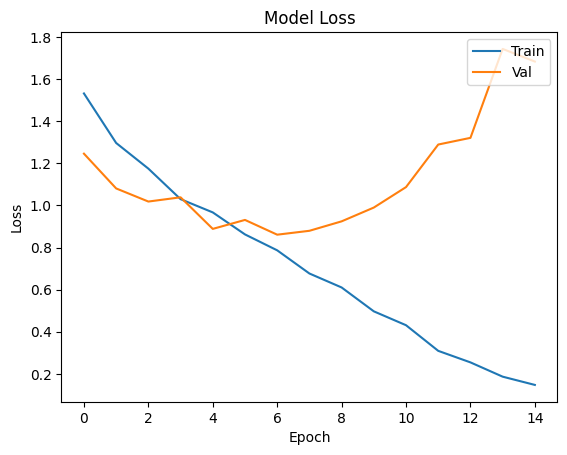

In [ ]:
plot_loss(history)

In [ ]:
model.evaluate(X_test, y_test, batch_size=32, verbose=1)

18/18 [==============================] - 6s 325ms/step - loss: 1.6764 - accuracy: 0.6551


[1.67638099193573, 0.6551094651222229]

In [ ]:
prediccion=model.predict(X_test, batch_size=32, verbose=1)  # Almacenamos todas las predicciones para los datos de test

18/18 [==============================] - 6s 297ms/step


In [ ]:
print(prediccion)
prediccion.shape

[[4.1197714e-01 5.4615659e-01 5.3011086e-03 6.0457392e-03 3.0516824e-02
  2.4397239e-06]
 [9.9981523e-01 4.8491696e-05 2.4582458e-05 5.9734516e-06 1.0567043e-04
  7.9496587e-13]
 [9.9787647e-01 2.5216118e-09 2.0443115e-03 2.7755450e-06 7.6484961e-05
  4.3877450e-16]
 ...
 [1.2398084e-03 1.1513219e-03 6.3857710e-01 2.7564727e-03 3.5627511e-01
  1.2643385e-07]
 [1.6906855e-06 8.3205487e-09 9.9919182e-01 1.0569601e-08 8.0652453e-04
  3.2945607e-14]
 [1.1303362e-09 6.5360579e-14 4.6951507e-04 4.2016995e-07 9.9953008e-01
  1.6849383e-20]]


(548, 6)

In [ ]:
print(prediccion[0]) # Ejemplo de predicción para el primer elemento del test.
predicho = np.argmax(prediccion[0])  # Nos quedamos con la posición del valor máximo de las estimaciones de probabilidad para cada una de las 18 clases.
print(predicho)
print(MAP_CHARACTERS[predicho]) # Acceso al diccionario para mostrar el nombre del personaje predicho.

[4.1197714e-01 5.4615659e-01 5.3011086e-03 6.0457392e-03 3.0516824e-02
 2.4397239e-06]
1
dandelion


In [ ]:
type(prediccion)

numpy.ndarray

In [ ]:
from sklearn.metrics import classification_report

# Suponiendo que tienes un diccionario que mapea los índices numéricos a las etiquetas deseadas
indice_a_etiqueta = {0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

# Creando un informe de clasificación con etiquetas personalizadas
etiquetas_personalizadas = [indice_a_etiqueta[i] for i in range(len(indice_a_etiqueta))]
informe = classification_report(np.argmax(y_test, axis=1), np.argmax(prediccion, axis=1), target_names=etiquetas_personalizadas)
print("\nInforme de Clasificación:")
print(informe)


Informe de Clasificación:
              precision    recall  f1-score   support

       daisy       0.60      0.72      0.65       100
   dandelion       0.78      0.60      0.68       129
        rose       0.50      0.55      0.52        99
   sunflower       0.82      0.81      0.82        99
       tulip       0.61      0.62      0.62       121

    accuracy                           0.66       548
   macro avg       0.66      0.66      0.66       548
weighted avg       0.67      0.66      0.66       548



In [ ]:
model.save('flowers.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 21.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
  Attempting uninstall: ml-dtypes
    F

In [ ]:
!mkdir carpeta_salida

In [ ]:
!tensorflowjs_converter --input_format keras flowers.h5 carpeta_salida

2024-04-25 17:38:03.267154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
